In [ ]:
# packages

import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lexicon Data
We load the [lexicon data](https://sraf.nd.edu/loughranmcdonald-master-dictionary/) used by the authors to supplant the VADER NLTK inbuilt lexicon for the purposes of our application



In [ ]:
# reading csv
LM_2011=pd.read_csv('/content/drive/MyDrive/Loughran-McDonald_MasterDictionary_1993-2021.csv')

In [ ]:
# "Unwrapping" the sentiment columns into lists of words corresponding to "Uncertain", "Constraining", "Positive" and "Negative"
# why >0, and not ==1? because instead of dummies, the years of added words to the dictionary are used. conversely, !=0 could be used too
negative_words = LM_2011[LM_2011['Negative'] > 0]['Word'].tolist()
positive_words = LM_2011[LM_2011['Positive'] > 0]['Word'].tolist()
uncertainty_words = LM_2011[LM_2011['Uncertainty'] > 0]['Word'].tolist()
uncertainty_words=[word.lower() for word in uncertainty_words]

constraining_words = LM_2011[LM_2011['Constraining']> 0]['Word'].tolist()

print([len(negative_words),len(positive_words),len(uncertainty_words),len(constraining_words)])

[2345, 347, 297, 184]


In [ ]:
# Bodnaruk's(2015) list of constraining words with which NLTK sentence sentiments will be reweighted
constraining_words=['abide', 'abiding', 'bound', 'bounded', 'commit', 'commitment', 'commitments', 'commits', 'committed', 'committing', 'compel', 'compelled', 'compelling', 'compels', 'comply', 'compulsion', 'compulsory', 'confine', 'confined', 'confinement', 'confines', 'confining', 'constrain', 'constrained', 'constraining', 'constrains', 'constraint', 'constraints', 'covenant', 'covenanted', 'covenanting', 'covenants', 'depend', 'dépendance', 'dependances', 'dependant', 'dependencies', 'dependent', 'depending', 'depends', 'dictate', 'dictated', 'dictates', 'dictating', 'directive', 'directives', 'earmark', 'earmarked', 'earmarking', 'earmarks', 'encumber', 'encumbered', 'encumbering', 'encumbers', 'encumbrance', 'encumbrances', 'entail', 'entailed', 'entailing', 'entails', 'entrench', 'entrenched', 'escrow', 'escrowed', 'escrows', 'forbade', 'forbid', 'forbidden', 'forbidding', 'forbids', 'impair', 'impaired', 'impairing', 'impairment', 'impairments', 'impairs', 'impose', 'imposed', 'imposes', 'imposing', 'imposition', 'impositions', 'indebted', 'inhibit', 'inhibited', 'inhibiting', 'inhibits', 'insist', 'insisted', 'insistence', 'insisting', 'insists', 'irrevocable', 'irrevocably', 'limit', 'limiting', 'limits', 'mandate', 'mandated', 'mandates', 'mandating', 'mandatory', 'manditorily', 'necessitate', 'necessitated', 'necessitates', 'necessitating', 'noncancelable', 'noncancellable', 'obligate', 'obligated', 'obligates', 'obligating', 'obligation', 'obligations', 'obligatory', 'oblige', 'obliged', 'obliges', 'permissible', 'permission', 'permissions', 'permitted', 'permitting', 'pledge', 'pledged', 'pledges', 'pledging', 'preclude', 'precluded', 'precludes', 'precluding', 'precondition', 'preconditions', 'preset', 'prevent', 'prevented', 'preventing', 'prevents', 'prohibit', 'prohibited', 'prohibiting', 'prohibition', 'prohibitions', 'prohibitive', 'prohibitively', 'prohibitory', 'prohibits', 'refrain', 'refraining', 'refrains', 'require', 'required', 'requirement', 'requirements', 'requires', 'requiring', 'restrain', 'restrained', 'restraining', 'restrains', 'restraint', 'restraints', 'restrict', 'restricted', 'restricting', 'restriction', 'restrictions', 'restrictive', 'restrictively', 'restrictiveness', 'restricts', 'stipulate', 'stipulated', 'stipulates', 'stipulating', 'stipulation', 'stipulations', 'strict', 'stricter', 'strictest', 'strictly', 'unavailability', 'unavailable']


In [ ]:
# Loading the statement data

fomc = pd.read_excel('/content/drive/MyDrive/FOMC_STATEMENTS.xlsx')
fomc=fomc[['Date','Statement']]

fomc

,Date,Statement
0,13.12.2023,Recent indicators suggest that growth of econo...
1,01.11.2023,Recent indicators suggest that economic activi...
2,20.09.2023,Recent indicators suggest that economic activi...
3,26.07.2023,Recent indicators suggest that economic activi...
4,14.06.2023,Recent indicators suggest that economic activi...
...,...,...
73,2013-07-31 00:00:00,Information received since the Federal Open Ma...
74,2013-06-19 00:00:00,Information received since the Federal Open Ma...
75,2013-05-01 00:00:00,Information received since the Federal Open Ma...
76,2013-03-20 00:00:00,Information received since the Federal Open Ma...


# Vader NLTK

As in Möller and Reichmann (2021), we make use of the Vader package and import the LM (2011) word list to somewhat approximate the sentiment-capturing approach of the authors, to be used in our event study.

The first task, as was the case in the Author's case, is to add additional words from the LM(2011) dictionary into the inbuilt Vader dictionary, i.e. "positive" and "negative" words.

[The Vader Documentation](https://vadersentiment.readthedocs.io/en/latest/pages/resource_description.html?highlight=lexicon) states that Vader is "sensitive to both polarity and intensity" meaning that the strength of sentiment can be specified too, by 4 stages (i.e. for "negative" from -1 to -4), which is why we decided to go with the level 2, given that "Horrible" is associated with 2.5 already.

In [ ]:
# for initializing VADER / usage:
sia = SentimentIntensityAnalyzer()

# Concatenating our words' sentiments
# to the Vader lexicon - now its a
# 'financeVader' of sorts

new_words = {word: 2.0 for
             word in
             positive_words}
new_words.update({word: -2.0
                  for word in
                  negative_words})
sia.lexicon.update(new_words)

## Getting the *Tone* right

In [ ]:
# sample of how this works

[sia.polarity_scores('You a pain in the ass, respectfully'), sia.polarity_scores('You a pain in the ass')]

[{'neg': 0.544, 'neu': 0.24, 'pos': 0.216, 'compound': -0.6249},
 {'neg': 0.694, 'neu': 0.306, 'pos': 0.0, 'compound': -0.7783}]

In [ ]:


# Function to calculate weighted sentiment for a statement
def weighted_sentiment(statement):
    # Tokenize into sentences
    sentences = tokenize.sent_tokenize(statement)
    # Get the total word count for the statement
    total_words = len(tokenize.word_tokenize(statement))

    # Calculate sentiment for each sentence and weight it
    weighted_scores = 0
    for sentence in sentences:
        # Get the sentiment score for the sentence
        sentiment_score = sia.polarity_scores(sentence)['compound']
        # weighting
        sentence_weight = len(tokenize.word_tokenize(sentence)) / total_words
        # Add the weighted score to total, and the += is used as an adding operator in for loops
        weighted_scores += sentiment_score * sentence_weight

    return weighted_scores

# Apply the weighted sentiment function to each row in the 'Statement' column
fomc['Tone'] = fomc['Statement'].apply(weighted_sentiment)




In [ ]:
fomc.tail()

,Date,Statement,Tone
73,2013-07-31 00:00:00,Information received since the Federal Open Ma...,0.214167
74,2013-06-19 00:00:00,Information received since the Federal Open Ma...,0.219595
75,2013-05-01 00:00:00,Information received since the Federal Open Ma...,0.226860
76,2013-03-20 00:00:00,Information received since the Federal Open Ma...,0.218299
77,2013-01-30 00:00:00,Information received since the Federal Open Ma...,0.158982


## Getting the *Uncertainty* right

We're remodelling the Vader lexicon. All the inbuilt words' sentiment scores will be reduced to 20% of their score, whereby our uncertainty word list will enter the lexicon with the values of -2. This way, we allow for words to interact but clearly aim towards singling out sentiments that emphasize uncertainty

In [ ]:
# resetting NLTK lexicon
sia = SentimentIntensityAnalyzer()

In [ ]:
# Modify the existing VADER lexicon to reduce the impact of its words
new_words = {word: 2.0*0.2 for word in positive_words}
new_words.update({word: -2.0*0.2 for word in negative_words})

modified_lexicon = {word: score * 0.2 for word, score in sia.lexicon.items()}
modified_lexicon.update(new_words)
sia.lexicon = modified_lexicon # Replace the entire lexicon

# Define your list of uncertainty words with a higher impact score
uncertainty_words_scores = {word: 2.0 for word in uncertainty_words}

# Update the lexicon with your uncertainty words scores
sia.lexicon.update(uncertainty_words_scores)


In [ ]:
# Function to calculate weighted sentiment for a statement
def weighted_sentiment(statement):
    # Tokenize into sentences
    sentences = tokenize.sent_tokenize(statement)
    # Get the total word count for the statement
    total_words = len(tokenize.word_tokenize(statement))

    # Calculate sentiment for each sentence and weight it
    weighted_scores = 0
    for sentence in sentences:
        # Get the sentiment score for the sentence
        sentiment_score = sia.polarity_scores(sentence)['compound']
        # weighting
        sentence_weight = len(tokenize.word_tokenize(sentence)) / total_words
        # Add the weighted score to total, and the += is used as an adding operator in for loops
        weighted_scores += sentiment_score * sentence_weight

    return weighted_scores

# Apply the weighted sentiment function to each row in the 'Statement' column
fomc['Unc'] = fomc['Statement'].apply(weighted_sentiment)

In [ ]:
fomc.head(10)

,Date,Statement,Tone,Unc
0,13.12.2023,Recent indicators suggest that growth of econo...,0.042163,0.195259
1,01.11.2023,Recent indicators suggest that economic activi...,0.023460,0.191942
2,20.09.2023,Recent indicators suggest that economic activi...,0.003494,0.189370
3,26.07.2023,Recent indicators suggest that economic activi...,-0.000555,0.190140
4,14.06.2023,Recent indicators suggest that economic activi...,0.013922,0.188975
5,03.05.2023,Economic activity expanded at a modest pace in...,-0.000558,0.171256
6,22.03.2023,Recent indicators point to modest growth in sp...,0.026065,0.156699
7,01.02.2023,Recent indicators point to modest growth in sp...,-0.041707,0.152102
8,14.12.2022,Recent indicators point to modest growth in sp...,-0.060071,0.148150
9,02.11.2022,Recent indicators point to modest growth in sp...,-0.053065,0.151392


## Getting the *Constraints* right

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
# Modify the existing VADER lexicon to reduce the impact of its words
new_words = {word: 2.0*0.2 for word in positive_words}
new_words.update({word: -2.0*0.2 for word in negative_words})

modified_lexicon = {word: score * 0.2 for word, score in sia.lexicon.items()}
modified_lexicon.update(new_words)
sia.lexicon = modified_lexicon # Replace the entire lexicon

# Define your list of uncertainty words with a higher impact score
constraining_words_scores = {word: 3.0 for word in constraining_words}

# Update the lexicon with your uncertainty words scores
sia.lexicon.update(constraining_words_scores)

In [ ]:
# Function to calculate weighted sentiment for a statement
def weighted_sentiment(statement):
    # Tokenize into sentences
    sentences = tokenize.sent_tokenize(statement)
    # Get the total word count for the statement
    total_words = len(tokenize.word_tokenize(statement))

    # Calculate sentiment for each sentence and weight it
    weighted_scores = 0
    for sentence in sentences:
        # Get the sentiment score for the sentence
        sentiment_score = sia.polarity_scores(sentence)['compound']
        # weighting
        sentence_weight = len(tokenize.word_tokenize(sentence)) / total_words
        # Add the weighted score to total, and the += is used as an adding operator in for loops
        weighted_scores += sentiment_score * sentence_weight

    return weighted_scores

# Apply the weighted sentiment function to each row in the 'Statement' column
fomc['Con'] = fomc['Statement'].apply(weighted_sentiment)

In [ ]:
fomc.head(5)

,Date,Statement,Tone,Unc,Con
0,13.12.2023,Recent indicators suggest that growth of econo...,0.042163,0.195259,0.034022
1,01.11.2023,Recent indicators suggest that economic activi...,0.023460,0.191942,0.028708
2,20.09.2023,Recent indicators suggest that economic activi...,0.003494,0.189370,0.024360
3,26.07.2023,Recent indicators suggest that economic activi...,-0.000555,0.190140,0.023688
4,14.06.2023,Recent indicators suggest that economic activi...,0.013922,0.188975,0.026159


### Visualizing our sentiment components

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.dates import DateFormatter
import seaborn as sns

In [ ]:
fomc['Date'] = pd.to_datetime(fomc['Date']).dt.strftime('%Y-%m-%d')
fomc['Date'] = pd.to_datetime(fomc['Date'], format='%Y-%m-%d')
fomc = fomc.sort_values('Date')

<ipython-input-22-20c26e985d41>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  fomc['Date'] = pd.to_datetime(fomc['Date']).dt.strftime('%Y-%m-%d')


In [ ]:
fomc.Con==fomc.Unc

77    False
76    False
75    False
74    False
73    False
      ...  
6     False
4     False
3     False
2     False
0     False
Length: 78, dtype: bool

In [ ]:
import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess  # Importing lowess
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Sample DataFrame 'fomc' with columns 'Date', 'Tone', 'Unc', 'Con'
# Assuming 'fomc' has already been created with the 'Date' column converted to datetime objects

# Calculate the lowess smoothed trend line for each sentiment
frac = 0.5  # Fraction of data used when estimating each y-value
smoothed_tone = lowess(fomc['Tone'], mdates.date2num(fomc['Date']), frac=frac)
smoothed_unc = lowess(fomc['Unc'], mdates.date2num(fomc['Date']), frac=frac)
smoothed_con = lowess(fomc['Con'], mdates.date2num(fomc['Date']), frac=frac)

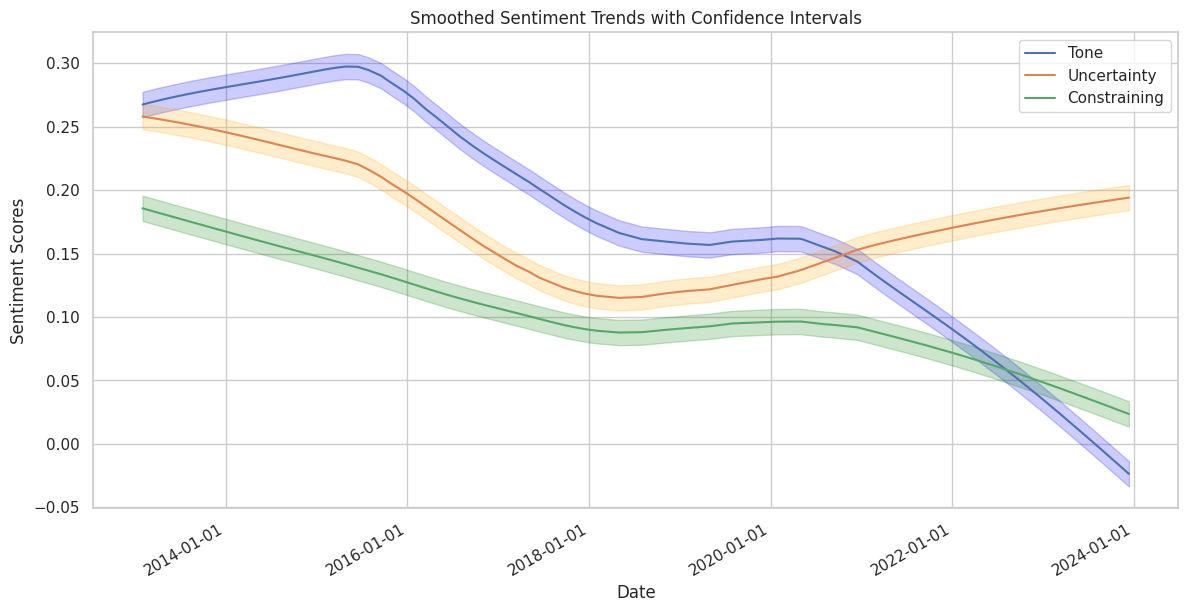

In [ ]:
# Set the figure size and style
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Plot the smoothed trend lines
plt.plot(mdates.num2date(smoothed_tone[:, 0]), smoothed_tone[:, 1], label='Tone')
plt.plot(mdates.num2date(smoothed_unc[:, 0]), smoothed_unc[:, 1], label='Uncertainty')
plt.plot(mdates.num2date(smoothed_con[:, 0]), smoothed_con[:, 1], label='Constraining')

# Assuming a fixed CI just to demonstrate the plotting (replace with actual CI calculations)
ci = 0.01  # Example confidence interval value
plt.fill_between(mdates.num2date(smoothed_tone[:, 0]), smoothed_tone[:, 1] - ci, smoothed_tone[:, 1] + ci, color='blue', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_unc[:, 0]), smoothed_unc[:, 1] - ci, smoothed_unc[:, 1] + ci, color='orange', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_con[:, 0]), smoothed_con[:, 1] - ci, smoothed_con[:, 1] + ci, color='green', alpha=0.2)

# Improve formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the dates on the x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Set locator

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adding legend, title, and labels
plt.legend()
plt.title('Smoothed Sentiment Trends with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sentiment Scores')

# Show the plot
plt.show()

In [ ]:
fomc

,Date,Statement,Tone,Unc,Con
77,2013-01-30,Information received since the Federal Open Ma...,0.158982,0.218965,0.145807
76,2013-03-20,Information received since the Federal Open Ma...,0.218299,0.222498,0.196278
75,2013-05-01,Information received since the Federal Open Ma...,0.226860,0.217891,0.188608
74,2013-06-19,Information received since the Federal Open Ma...,0.219595,0.208304,0.186254
73,2013-07-31,Information received since the Federal Open Ma...,0.214167,0.223509,0.186759
...,...,...,...,...,...
6,2023-03-22,Recent indicators point to modest growth in sp...,0.026065,0.156699,0.084138
4,2023-06-14,Recent indicators suggest that economic activi...,0.013922,0.188975,0.026159
3,2023-07-26,Recent indicators suggest that economic activi...,-0.000555,0.190140,0.023688
2,2023-09-20,Recent indicators suggest that economic activi...,0.003494,0.189370,0.024360


In [ ]:
fomc.to_excel('/content/drive/MyDrive/SENTIMENTS_FOMC_FINAL.xlsx', index=False)

# FinBERT FOMC Sentiment Approach

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

In [ ]:
finbert = BertForSequenceClassification.from_pretrained('ZiweiChen/FinBERT-FOMC',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('ZiweiChen/FinBERT-FOMC')
finbert_fomc = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
def bert_sentiment(statement):
    # Tokenize into sentences
    sentences = tokenize.sent_tokenize(statement)
    # Get the total word count for the statement
    total_words = len(tokenize.word_tokenize(statement))

    # Calculate sentiment for each sentence and weight it
    weighted_scores = 0
    for sentence in sentences:
        # Get the sentiment score for the sentence
        sentiment_score = finbert_fomc(sentence)[0]['score']
        # weighting
        sentence_weight = len(tokenize.word_tokenize(sentence)) / total_words
        # Add the weighted score to total, and the += is used as an adding operator in for loops
        weighted_scores += sentiment_score * sentence_weight

    return weighted_scores

In [ ]:
fomc['Bert'] = fomc['Statement'].apply(bert_sentiment)

In [ ]:
fomc.var()

<ipython-input-39-9ae428623dfc>:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  fomc.var()


Tone    0.016221
Unc     0.003795
Con     0.002620
Bert    0.000750
dtype: float64

In [ ]:
fomc.head(50)

,Date,Statement,Tone,Unc,Con,Bert
77,2013-01-30,Information received since the Federal Open Ma...,0.158982,0.218965,0.145807,0.899695
76,2013-03-20,Information received since the Federal Open Ma...,0.218299,0.222498,0.196278,0.871355
75,2013-05-01,Information received since the Federal Open Ma...,0.226860,0.217891,0.188608,0.868783
74,2013-06-19,Information received since the Federal Open Ma...,0.219595,0.208304,0.186254,0.887783
73,2013-07-31,Information received since the Federal Open Ma...,0.214167,0.223509,0.186759,0.904340
72,2013-09-18,Information received since the Federal Open Ma...,0.328732,0.292917,0.175251,0.943618
71,2013-10-30,Information received since the Federal Open Ma...,0.287443,0.276222,0.148949,0.944651
70,2013-12-18,Information received since the Federal Open Ma...,0.297705,0.230987,0.155775,0.938980
69,2014-01-29,Information received since the Federal Open Ma...,0.312795,0.225664,0.157624,0.934972
68,2014-03-19,Information received since the Federal Open Ma...,0.397755,0.274117,0.174250,0.932421


In [ ]:
fomc['Bert_normed']= fomc['Bert']*(fomc['Tone'][77]/fomc['Bert'][77])

In [ ]:
fomc.to_excel('/content/drive/MyDrive/SENTIMENTS_FOMC_FINAL_with_BERT.xlsx', index=False)

**UP TO HERE CODE SHOULD BE PROPER** - after **this point** experiments/graveyard

In [ ]:
Core=pd.read_excel('/content/drive/MyDrive/Core.xlsx')

In [ ]:
ir_data=Core[['Date','IR']]

In [ ]:
# Calculate the lowess smoothed trend line for each sentiment
frac = .1 # Fraction of data used when estimating each y-value
smoothed_bert = lowess(fomc['Bert_normed'], mdates.date2num(fomc['Date']), frac=frac)

<ipython-input-47-30d20d9dbcbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir_data['Date'] = pd.to_datetime(ir_data['Date'])
<ipython-input-47-30d20d9dbcbf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir_data.sort_values('Date', inplace=True)


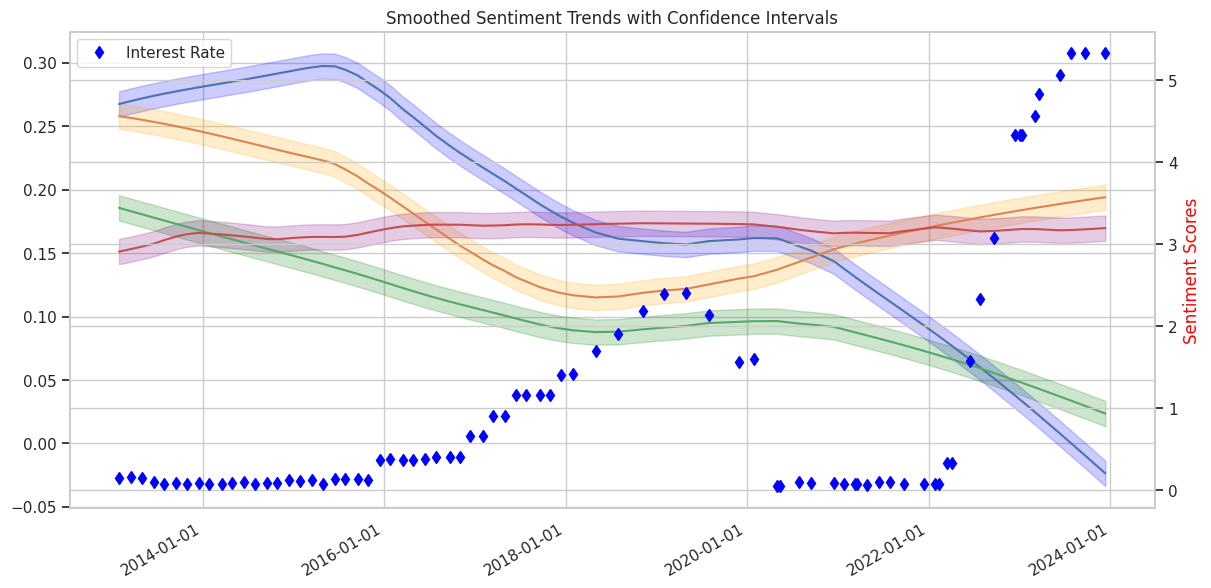

In [ ]:
ir_data['Date'] = pd.to_datetime(ir_data['Date'])
ir_data.sort_values('Date', inplace=True)

# Create the plot for sentiment scores as you've done before
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
# Plot the smoothed trend lines
plt.plot(mdates.num2date(smoothed_tone[:, 0]), smoothed_tone[:, 1], label='Tone')
plt.plot(mdates.num2date(smoothed_unc[:, 0]), smoothed_unc[:, 1], label='Uncertainty')
plt.plot(mdates.num2date(smoothed_con[:, 0]), smoothed_con[:, 1], label='Constraining')
plt.plot(mdates.num2date(smoothed_con[:, 0]), smoothed_bert[:, 1], label='BerTone')

# Assuming a fixed CI just to demonstrate the plotting (replace with actual CI calculations)
ci = 0.01  # Example confidence interval value
plt.fill_between(mdates.num2date(smoothed_tone[:, 0]), smoothed_tone[:, 1] - ci, smoothed_tone[:, 1] + ci, color='blue', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_unc[:, 0]), smoothed_unc[:, 1] - ci, smoothed_unc[:, 1] + ci, color='orange', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_con[:, 0]), smoothed_con[:, 1] - ci, smoothed_con[:, 1] + ci, color='green', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_con[:, 0]), smoothed_bert[:, 1] - ci, smoothed_bert[:, 1] + ci, color='purple', alpha=0.2)

ax2 = plt.gca().twinx()

# Plot the IR data
ax2.plot(ir_data['Date'], ir_data['IR'], 'd', color='Blue', label='Interest Rate')  # 'd' for diamond marker

# Set the y-axis label for the IR data
ax2.set_ylabel('Interest Rate', color='red')

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adding legend to the right axis
ax2.legend(loc='upper left')

# Improve formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the dates on the x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Set locator

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adding legend, title, and labels
plt.legend()
plt.title('Smoothed Sentiment Trends with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sentiment Scores')

# Show the plot
plt.show()

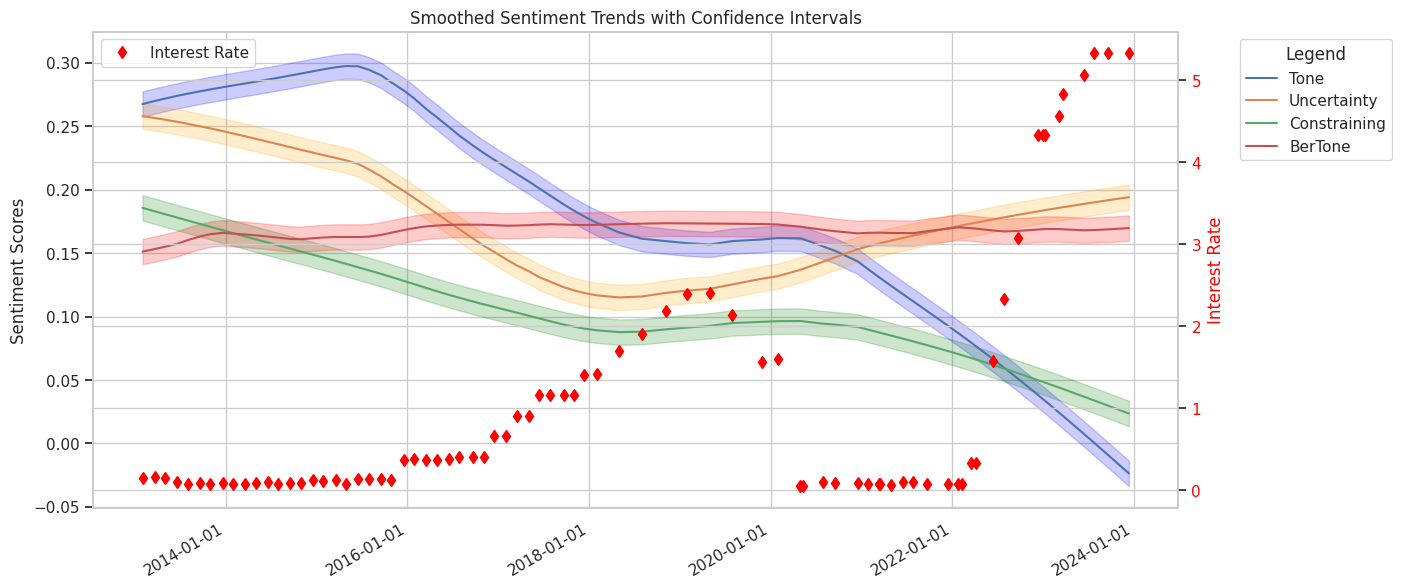

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ... your data loading and processing ...

# Create the plot for sentiment scores
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Plot the smoothed trend lines for sentiment
plt.plot(mdates.num2date(smoothed_tone[:, 0]), smoothed_tone[:, 1], label='Tone')
plt.plot(mdates.num2date(smoothed_unc[:, 0]), smoothed_unc[:, 1], label='Uncertainty')
plt.plot(mdates.num2date(smoothed_con[:, 0]), smoothed_con[:, 1], label='Constraining')
plt.plot(mdates.num2date(smoothed_con[:, 0]), smoothed_bert[:, 1], label='BerTone')

# Fill between for confidence intervals
ci = 0.01  # Example confidence interval value
plt.fill_between(mdates.num2date(smoothed_tone[:, 0]), smoothed_tone[:, 1] - ci, smoothed_tone[:, 1] + ci, color='blue', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_unc[:, 0]), smoothed_unc[:, 1] - ci, smoothed_unc[:, 1] + ci, color='orange', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_con[:, 0]), smoothed_con[:, 1] - ci, smoothed_con[:, 1] + ci, color='green', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_con[:, 0]), smoothed_bert[:, 1] - ci, smoothed_bert[:, 1] + ci, color='red', alpha=0.2)

# Set primary y-axis label
plt.ylabel('Sentiment Scores')

# Add legend for sentiment trends
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Create a second y-axis for the IR data
ax2 = plt.gca().twinx()

# Plot the IR data as diamonds
ax2.plot(ir_data['Date'], ir_data['IR'], 'd', color='red', label='Interest Rate')  # 'd' for diamond marker

# Set the secondary y-axis label and change its color to match the plot
ax2.set_ylabel('Interest Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend for IR data on the second y-axis
ax2.legend(loc='upper left')

# Title and x-axis label
plt.title('Smoothed Sentiment Trends with Confidence Intervals')
plt.xlabel('Date')

# Show the plot
plt.show()


<ipython-input-51-8199892ce295>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir_data['Date'] = pd.to_datetime(ir_data['Date'])
<ipython-input-51-8199892ce295>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir_data.sort_values('Date', inplace=True)


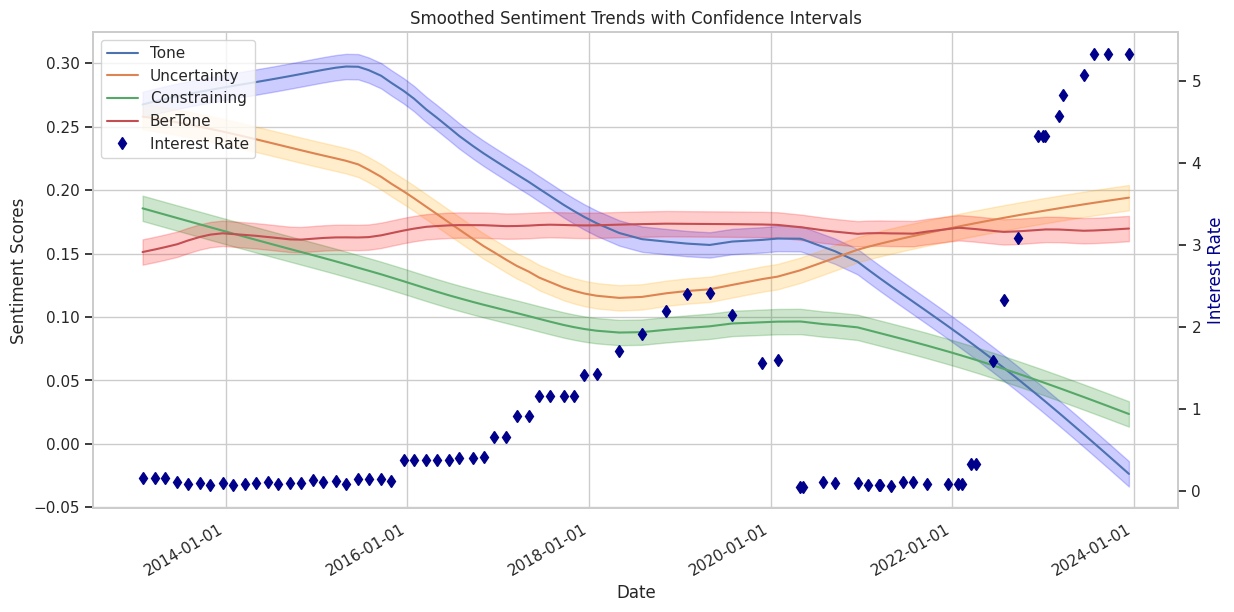

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np

# Assume ir_data, smoothed_tone, smoothed_unc, smoothed_con, smoothed_bert are defined
# For example, let's say ir_data is a DataFrame with 'Date' and 'IR' columns

# Convert 'Date' to datetime and sort the DataFrame
ir_data['Date'] = pd.to_datetime(ir_data['Date'])
ir_data.sort_values('Date', inplace=True)

# Create the plot for sentiment scores as you've done before
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Plot the smoothed trend lines for sentiment scores
plt.plot(mdates.num2date(smoothed_tone[:, 0]), smoothed_tone[:, 1], label='Tone')
plt.plot(mdates.num2date(smoothed_unc[:, 0]), smoothed_unc[:, 1], label='Uncertainty')
plt.plot(mdates.num2date(smoothed_con[:, 0]), smoothed_con[:, 1], label='Constraining')
plt.plot(mdates.num2date(smoothed_con[:, 0]), smoothed_bert[:, 1], label='BerTone')

# Assuming a fixed CI just to demonstrate the plotting (replace with actual CI calculations)
ci = 0.01  # Example confidence interval value
plt.fill_between(mdates.num2date(smoothed_tone[:, 0]), smoothed_tone[:, 1] - ci, smoothed_tone[:, 1] + ci, color='blue', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_unc[:, 0]), smoothed_unc[:, 1] - ci, smoothed_unc[:, 1] + ci, color='orange', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_con[:, 0]), smoothed_con[:, 1] - ci, smoothed_con[:, 1] + ci, color='green', alpha=0.2)
plt.fill_between(mdates.num2date(smoothed_con[:, 0]), smoothed_bert[:, 1] - ci, smoothed_bert[:, 1] + ci, color='red', alpha=0.2)

# Create a secondary y-axis for the IR data
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot the IR data
ax2.plot(ir_data['Date'], ir_data['IR'], 'd', color='darkblue', label='Interest Rate')  # 'd' for diamond marker

# Set the y-axis label for the IR data
ax2.set_ylabel('Interest Rate', color='darkblue')

# Remove gridlines from the interest rate axis
ax2.grid(False)

# Create a legend for all items
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Formatting dates on the x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adding title and axis labels
plt.title('Smoothed Sentiment Trends with Confidence Intervals')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Scores')

# Show the plot
plt.show()


In [ ]:

# Define your specialized word lists
uncertainty_words = set([...])  # Load your actual words here
constraining_words = set([...])  # Load your actual words here

# Function to calculate sentiment for a whole statement
def statement_sentiment(statement, uncertainty_words, constraining_words):
    sentences = nltk.sent_tokenize(statement)
    tone_scores = [reweight_vader_score(sentence, uncertainty_words | constraining_words) for sentence in sentences]
    unc_scores = [reweight_vader_score(sentence, uncertainty_words) for sentence in sentences]
    con_scores = [reweight_vader_score(sentence, constraining_words) for sentence in sentences]

    # Calculate aggregate score; you can choose average, sum, or any other method
    tone = sum(tone_scores) / len(sentences) if sentences else 0
    unc = sum(unc_scores) / len(sentences) if sentences else 0
    con = sum(con_scores) / len(sentences) if sentences else 0

    return tone, unc, con

# Apply sentiment analysis to each statement
results = df['Statement_Column_Name'].apply(lambda x: statement_sentiment(x, uncertainty_words, constraining_words))

# The results are tuples, so separate them into different columns
df['Tone'] = results.apply(lambda x: x[0])
df['Uncertainty'] = results.apply(lambda x: x[1])
df['Constraining'] = results.apply(lambda x: x[2])

# Save the results back to a new Excel file
df.to_excel('path_to_your_output_excel_file.xlsx', index=False)


NameError: name 'df' is not defined